# Classification EEG using LSTM

## Import library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Device: GPU or CPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Load dataset

In [3]:
import numpy as np
filename = 'data/eeg/sub-01/preprocessed_eeg_training.npy'
eeg_data = np.load(filename, allow_pickle=True).item()['preprocessed_eeg_data']
eeg_data = np.mean(eeg_data, axis=1)

filename = 'data/img/image_metadata.npy'
label_data = np.load(filename, allow_pickle=True).item()['train_img_concepts']
label_data = [x[6:] for x in label_data]
label_data_num = []
for i, name in enumerate(sorted(list(set(label_data)))):
    for j in range(10):
        label_data_num.append(i)
label_data_num = np.array(label_data_num)

In [5]:
train_dataset, test_dataset, train_label, test_label = train_test_split(eeg_data, label_data_num, test_size=0.2, stratify=label_data_num)
train_dataset, val_dataset, train_label, val_label = train_test_split(train_dataset, train_label, test_size=0.2, stratify=train_label)

transform_dataset = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])   
train_dataset = transform_dataset(train_dataset).permute(1, 0, 2)
val_dataset = transform_dataset(val_dataset).permute(1, 0, 2)
test_dataset = transform_dataset(test_dataset).permute(1, 0, 2)
train_label = torch.LongTensor(train_label)
val_label = torch.LongTensor(val_label)
test_label = torch.LongTensor(test_label)

train_dataset = TensorDataset(train_dataset, train_label)
val_dataset = TensorDataset(val_dataset, val_label)
test_dataset = TensorDataset(test_dataset, test_label)

## Create Detaloader

In [6]:
batch_size = 256
train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=30)
val_dataloader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=30)
test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=30)
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

## LSTM

In [8]:
class Net(nn.Module):

    def __init__(self):
        
        super(Net, self).__init__()
        self.seq_len = 100
        self.feature_size = 17
        self.hidden_layer_size = 256
        self.lstm_layers = 50
        self.class_n = 1654
        
        self.lstm = nn.LSTM(self.feature_size, 
                            self.hidden_layer_size, 
                            num_layers = self.lstm_layers,
                            dropout=0.5)
        
        self.fc = nn.Linear(self.hidden_layer_size, self.class_n)
        
    def init_hidden_cell(self, batch_size):
        hedden = torch.zeros(self.lstm_layers, batch_size, self.hidden_layer_size).to(device)
        cell = torch.zeros(self.lstm_layers, batch_size, self.hidden_layer_size).to(device)        
        return (hedden, cell)

    def forward(self, x):
        batch_size = x.shape[0]
        self.hidden_cell = self.init_hidden_cell(batch_size)
        x = x.float().view(batch_size, self.seq_len, self.feature_size)  # (Batch, Cannel, Height, Width) -> (Batch, Height, Width) = (Batch, Seqence, Feature)
        x = x.permute(1, 0, 2)                                   # (Batch, Seqence, Feature) -> (Seqence , Batch, Feature)
        lstm_out, (h_n, c_n) = self.lstm(x, self.hidden_cell)    # LSTM input: (Seqence, Batch, Feature)
                                                                 # h_n Shape: (num_layers, batch, hidden_size)
        x = h_n[-1,:,:]
        x = self.fc(x)
        return x
    
net = Net().to(device)

## Define Loss Function & Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train & Validation

In [10]:
def train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs):
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval() 

            epoch_loss = 0.0
            epoch_corrects = 0

            if (epoch == 0) and (phase == 'train'):
                continue

            for i , (inputs, labels) in tqdm(enumerate(dataloaders_dict[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)  
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                    train_loss_list.append(epoch_loss)
                    train_acc_list.append(epoch_acc)
            else:
                    val_loss_list.append(epoch_loss)
                    val_acc_list.append(epoch_acc)  
    return {'train_loss':train_loss_list, 'train_acc':train_acc_list, 'val_loss':val_loss_list, 'val_acc':val_acc_list}

In [11]:
num_epochs = 1000
history = train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs=num_epochs)

Epoch 1/1000
-------------


11it [00:02,  5.16it/s]

val Loss: 7.4122 Acc: 0.0004
Epoch 2/1000
-------------



42it [00:26,  1.59it/s]

train Loss: 7.4135 Acc: 0.0004



11it [00:02,  5.13it/s]

val Loss: 7.4164 Acc: 0.0008
Epoch 3/1000
-------------



42it [00:26,  1.57it/s]

train Loss: 7.4146 Acc: 0.0007



11it [00:02,  5.12it/s]

val Loss: 7.4138 Acc: 0.0004
Epoch 4/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4136 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4144 Acc: 0.0004
Epoch 5/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4128 Acc: 0.0009



11it [00:02,  5.08it/s]

val Loss: 7.4153 Acc: 0.0004
Epoch 6/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4154 Acc: 0.0008



11it [00:02,  5.06it/s]

val Loss: 7.4156 Acc: 0.0004
Epoch 7/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4139 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4163 Acc: 0.0004
Epoch 8/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4128 Acc: 0.0006



11it [00:02,  5.01it/s]

val Loss: 7.4151 Acc: 0.0004
Epoch 9/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4134 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4160 Acc: 0.0004
Epoch 10/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4133 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4156 Acc: 0.0004
Epoch 11/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4125 Acc: 0.0009



11it [00:02,  5.06it/s]

val Loss: 7.4166 Acc: 0.0004
Epoch 12/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4123 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4170 Acc: 0.0004
Epoch 13/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4119 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4173 Acc: 0.0004
Epoch 14/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4116 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4179 Acc: 0.0004
Epoch 15/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4117 Acc: 0.0006



11it [00:02,  5.06it/s]

val Loss: 7.4181 Acc: 0.0004
Epoch 16/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4114 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4185 Acc: 0.0004
Epoch 17/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4115 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4189 Acc: 0.0004
Epoch 18/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4114 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4195 Acc: 0.0004
Epoch 19/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4114 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4197 Acc: 0.0004
Epoch 20/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4112 Acc: 0.0002



11it [00:02,  5.09it/s]

val Loss: 7.4200 Acc: 0.0004
Epoch 21/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4111 Acc: 0.0003



11it [00:02,  5.10it/s]

val Loss: 7.4206 Acc: 0.0004
Epoch 22/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4110 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4208 Acc: 0.0004
Epoch 23/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4110 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4212 Acc: 0.0004
Epoch 24/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4109 Acc: 0.0002



11it [00:02,  5.08it/s]

val Loss: 7.4214 Acc: 0.0004
Epoch 25/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4109 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4218 Acc: 0.0004
Epoch 26/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4108 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4223 Acc: 0.0004
Epoch 27/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4110 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4225 Acc: 0.0004
Epoch 28/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4107 Acc: 0.0004



11it [00:02,  4.97it/s]

val Loss: 7.4230 Acc: 0.0004
Epoch 29/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4107 Acc: 0.0006



11it [00:02,  5.09it/s]

val Loss: 7.4233 Acc: 0.0004
Epoch 30/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4106 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4235 Acc: 0.0004
Epoch 31/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4106 Acc: 0.0002



11it [00:02,  5.02it/s]

val Loss: 7.4237 Acc: 0.0004
Epoch 32/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4106 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4241 Acc: 0.0004
Epoch 33/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4106 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4242 Acc: 0.0004
Epoch 34/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4105 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4242 Acc: 0.0004
Epoch 35/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4105 Acc: 0.0003



11it [00:02,  4.99it/s]

val Loss: 7.4250 Acc: 0.0004
Epoch 36/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4104 Acc: 0.0008



11it [00:02,  5.08it/s]

val Loss: 7.4245 Acc: 0.0004
Epoch 37/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4104 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4249 Acc: 0.0004
Epoch 38/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4103 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4252 Acc: 0.0004
Epoch 39/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4104 Acc: 0.0002



11it [00:02,  5.04it/s]

val Loss: 7.4257 Acc: 0.0004
Epoch 40/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4103 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4258 Acc: 0.0004
Epoch 41/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4102 Acc: 0.0004



11it [00:02,  5.10it/s]

val Loss: 7.4257 Acc: 0.0004
Epoch 42/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4102 Acc: 0.0002



11it [00:02,  5.09it/s]

val Loss: 7.4265 Acc: 0.0004
Epoch 43/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4102 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4267 Acc: 0.0004
Epoch 44/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4101 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4267 Acc: 0.0004
Epoch 45/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4101 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4266 Acc: 0.0004
Epoch 46/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4102 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4270 Acc: 0.0004
Epoch 47/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4101 Acc: 0.0002



11it [00:02,  5.06it/s]

val Loss: 7.4271 Acc: 0.0004
Epoch 48/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4101 Acc: 0.0001



11it [00:02,  5.07it/s]

val Loss: 7.4268 Acc: 0.0004
Epoch 49/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4101 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4275 Acc: 0.0004
Epoch 50/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4100 Acc: 0.0003



11it [00:02,  5.10it/s]

val Loss: 7.4269 Acc: 0.0004
Epoch 51/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4099 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4275 Acc: 0.0004
Epoch 52/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4100 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4278 Acc: 0.0004
Epoch 53/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4099 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4282 Acc: 0.0004
Epoch 54/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4099 Acc: 0.0001



11it [00:02,  5.08it/s]

val Loss: 7.4284 Acc: 0.0004
Epoch 55/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4099 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4284 Acc: 0.0004
Epoch 56/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4098 Acc: 0.0003



11it [00:02,  5.11it/s]

val Loss: 7.4283 Acc: 0.0004
Epoch 57/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4098 Acc: 0.0002



11it [00:02,  5.09it/s]

val Loss: 7.4282 Acc: 0.0004
Epoch 58/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4099 Acc: 0.0004



11it [00:02,  5.12it/s]

val Loss: 7.4290 Acc: 0.0004
Epoch 59/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4099 Acc: 0.0006



11it [00:02,  5.09it/s]

val Loss: 7.4287 Acc: 0.0004
Epoch 60/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4097 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4284 Acc: 0.0004
Epoch 61/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4098 Acc: 0.0006



11it [00:02,  5.09it/s]

val Loss: 7.4289 Acc: 0.0004
Epoch 62/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4098 Acc: 0.0003



11it [00:02,  5.10it/s]

val Loss: 7.4289 Acc: 0.0004
Epoch 63/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4098 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4295 Acc: 0.0004
Epoch 64/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4097 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4291 Acc: 0.0004
Epoch 65/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4096 Acc: 0.0006



11it [00:02,  5.09it/s]

val Loss: 7.4292 Acc: 0.0004
Epoch 66/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4097 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4294 Acc: 0.0004
Epoch 67/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4097 Acc: 0.0006



11it [00:02,  5.10it/s]

val Loss: 7.4292 Acc: 0.0004
Epoch 68/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4097 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4298 Acc: 0.0004
Epoch 69/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4096 Acc: 0.0002



11it [00:02,  5.06it/s]

val Loss: 7.4295 Acc: 0.0004
Epoch 70/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4096 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4298 Acc: 0.0004
Epoch 71/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4096 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4293 Acc: 0.0004
Epoch 72/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4097 Acc: 0.0007



11it [00:02,  5.12it/s]

val Loss: 7.4296 Acc: 0.0004
Epoch 73/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4096 Acc: 0.0005



11it [00:02,  5.11it/s]

val Loss: 7.4300 Acc: 0.0004
Epoch 74/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4096 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4299 Acc: 0.0004
Epoch 75/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4096 Acc: 0.0003



11it [00:02,  5.11it/s]

val Loss: 7.4297 Acc: 0.0004
Epoch 76/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4095 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4299 Acc: 0.0004
Epoch 77/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4095 Acc: 0.0006



11it [00:02,  5.09it/s]

val Loss: 7.4299 Acc: 0.0004
Epoch 78/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4095 Acc: 0.0003



11it [00:02,  5.02it/s]

val Loss: 7.4305 Acc: 0.0004
Epoch 79/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4095 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4302 Acc: 0.0004
Epoch 80/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4095 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4303 Acc: 0.0004
Epoch 81/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4095 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4305 Acc: 0.0004
Epoch 82/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4095 Acc: 0.0004



11it [00:02,  5.12it/s]

val Loss: 7.4308 Acc: 0.0004
Epoch 83/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4095 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4311 Acc: 0.0004
Epoch 84/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4303 Acc: 0.0004
Epoch 85/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0001



11it [00:02,  5.11it/s]

val Loss: 7.4304 Acc: 0.0004
Epoch 86/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0006



11it [00:02,  5.10it/s]

val Loss: 7.4311 Acc: 0.0004
Epoch 87/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4095 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4309 Acc: 0.0004
Epoch 88/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4309 Acc: 0.0004
Epoch 89/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4309 Acc: 0.0004
Epoch 90/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4311 Acc: 0.0004
Epoch 91/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0006



11it [00:02,  5.08it/s]

val Loss: 7.4310 Acc: 0.0004
Epoch 92/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4094 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4312 Acc: 0.0004
Epoch 93/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0007



11it [00:02,  5.11it/s]

val Loss: 7.4309 Acc: 0.0004
Epoch 94/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4311 Acc: 0.0004
Epoch 95/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4312 Acc: 0.0004
Epoch 96/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4315 Acc: 0.0004
Epoch 97/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4094 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4310 Acc: 0.0004
Epoch 98/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4094 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4314 Acc: 0.0004
Epoch 99/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4314 Acc: 0.0004
Epoch 100/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4093 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4318 Acc: 0.0004
Epoch 101/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0001



11it [00:02,  5.07it/s]

val Loss: 7.4313 Acc: 0.0004
Epoch 102/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4314 Acc: 0.0004
Epoch 103/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4093 Acc: 0.0006



11it [00:02,  5.10it/s]

val Loss: 7.4318 Acc: 0.0004
Epoch 104/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4094 Acc: 0.0006



11it [00:02,  5.06it/s]

val Loss: 7.4317 Acc: 0.0004
Epoch 105/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0005



11it [00:02,  4.82it/s]

val Loss: 7.4317 Acc: 0.0004
Epoch 106/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4093 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4317 Acc: 0.0004
Epoch 107/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4322 Acc: 0.0004
Epoch 108/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4320 Acc: 0.0004
Epoch 109/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4321 Acc: 0.0004
Epoch 110/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4319 Acc: 0.0004
Epoch 111/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4093 Acc: 0.0003



11it [00:02,  5.11it/s]

val Loss: 7.4322 Acc: 0.0004
Epoch 112/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4093 Acc: 0.0006



11it [00:02,  5.07it/s]

val Loss: 7.4321 Acc: 0.0004
Epoch 113/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4317 Acc: 0.0004
Epoch 114/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0006



11it [00:02,  5.03it/s]

val Loss: 7.4321 Acc: 0.0004
Epoch 115/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4322 Acc: 0.0004
Epoch 116/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0006



11it [00:02,  5.11it/s]

val Loss: 7.4323 Acc: 0.0004
Epoch 117/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4092 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4320 Acc: 0.0004
Epoch 118/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4092 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4326 Acc: 0.0004
Epoch 119/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4322 Acc: 0.0004
Epoch 120/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4093 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4324 Acc: 0.0004
Epoch 121/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4325 Acc: 0.0004
Epoch 122/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4325 Acc: 0.0004
Epoch 123/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4327 Acc: 0.0004
Epoch 124/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0008



11it [00:02,  5.07it/s]

val Loss: 7.4324 Acc: 0.0004
Epoch 125/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4327 Acc: 0.0004
Epoch 126/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4326 Acc: 0.0004
Epoch 127/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0006



11it [00:02,  5.06it/s]

val Loss: 7.4328 Acc: 0.0004
Epoch 128/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4092 Acc: 0.0003



11it [00:02,  5.12it/s]

val Loss: 7.4327 Acc: 0.0004
Epoch 129/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4327 Acc: 0.0004
Epoch 130/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4326 Acc: 0.0004
Epoch 131/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4326 Acc: 0.0004
Epoch 132/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4326 Acc: 0.0004
Epoch 133/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4333 Acc: 0.0004
Epoch 134/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4092 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4331 Acc: 0.0004
Epoch 135/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4092 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4328 Acc: 0.0004
Epoch 136/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4329 Acc: 0.0004
Epoch 137/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4329 Acc: 0.0004
Epoch 138/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4330 Acc: 0.0004
Epoch 139/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0006



11it [00:02,  5.06it/s]

val Loss: 7.4331 Acc: 0.0004
Epoch 140/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4330 Acc: 0.0004
Epoch 141/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4330 Acc: 0.0004
Epoch 142/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.11it/s]

val Loss: 7.4331 Acc: 0.0004
Epoch 143/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4092 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4335 Acc: 0.0004
Epoch 144/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4329 Acc: 0.0004
Epoch 145/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4332 Acc: 0.0004
Epoch 146/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4336 Acc: 0.0004
Epoch 147/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4091 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4333 Acc: 0.0004
Epoch 148/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0000



11it [00:02,  5.04it/s]

val Loss: 7.4331 Acc: 0.0004
Epoch 149/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4338 Acc: 0.0004
Epoch 150/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0001



11it [00:02,  5.08it/s]

val Loss: 7.4334 Acc: 0.0004
Epoch 151/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4331 Acc: 0.0004
Epoch 152/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.12it/s]

val Loss: 7.4336 Acc: 0.0004
Epoch 153/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4091 Acc: 0.0004



11it [00:02,  5.10it/s]

val Loss: 7.4336 Acc: 0.0004
Epoch 154/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4332 Acc: 0.0004
Epoch 155/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4337 Acc: 0.0004
Epoch 156/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0002



11it [00:02,  5.05it/s]

val Loss: 7.4333 Acc: 0.0004
Epoch 157/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4335 Acc: 0.0004
Epoch 158/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0006



11it [00:02,  5.08it/s]

val Loss: 7.4335 Acc: 0.0004
Epoch 159/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4333 Acc: 0.0004
Epoch 160/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4338 Acc: 0.0004
Epoch 161/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 162/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4091 Acc: 0.0002



11it [00:02,  5.09it/s]

val Loss: 7.4337 Acc: 0.0004
Epoch 163/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4336 Acc: 0.0004
Epoch 164/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 165/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4091 Acc: 0.0006



11it [00:02,  5.08it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 166/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4337 Acc: 0.0004
Epoch 167/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0008



11it [00:02,  5.04it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 168/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4091 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 169/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4338 Acc: 0.0004
Epoch 170/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 171/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0006



11it [00:02,  4.79it/s]

val Loss: 7.4341 Acc: 0.0004
Epoch 172/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4090 Acc: 0.0006



11it [00:02,  5.01it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 173/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0002



11it [00:02,  5.03it/s]

val Loss: 7.4341 Acc: 0.0004
Epoch 174/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 175/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.12it/s]

val Loss: 7.4344 Acc: 0.0004
Epoch 176/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4090 Acc: 0.0004



11it [00:02,  5.11it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 177/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.12it/s]

val Loss: 7.4342 Acc: 0.0004
Epoch 178/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4344 Acc: 0.0004
Epoch 179/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4339 Acc: 0.0004
Epoch 180/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4343 Acc: 0.0004
Epoch 181/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4343 Acc: 0.0004
Epoch 182/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0004



11it [00:02,  5.10it/s]

val Loss: 7.4343 Acc: 0.0004
Epoch 183/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4341 Acc: 0.0004
Epoch 184/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4345 Acc: 0.0004
Epoch 185/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0006



11it [00:02,  5.02it/s]

val Loss: 7.4344 Acc: 0.0004
Epoch 186/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4342 Acc: 0.0004
Epoch 187/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4345 Acc: 0.0004
Epoch 188/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4346 Acc: 0.0004
Epoch 189/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4345 Acc: 0.0004
Epoch 190/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4344 Acc: 0.0004
Epoch 191/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4345 Acc: 0.0004
Epoch 192/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4347 Acc: 0.0004
Epoch 193/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4349 Acc: 0.0004
Epoch 194/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4342 Acc: 0.0004
Epoch 195/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4347 Acc: 0.0004
Epoch 196/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.11it/s]

val Loss: 7.4345 Acc: 0.0004
Epoch 197/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4347 Acc: 0.0004
Epoch 198/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4349 Acc: 0.0004
Epoch 199/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.12it/s]

val Loss: 7.4350 Acc: 0.0004
Epoch 200/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4348 Acc: 0.0004
Epoch 201/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4351 Acc: 0.0004
Epoch 202/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4347 Acc: 0.0004
Epoch 203/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4350 Acc: 0.0004
Epoch 204/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4348 Acc: 0.0004
Epoch 205/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4350 Acc: 0.0004
Epoch 206/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4349 Acc: 0.0004
Epoch 207/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4352 Acc: 0.0004
Epoch 208/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4351 Acc: 0.0004
Epoch 209/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4351 Acc: 0.0004
Epoch 210/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4090 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4354 Acc: 0.0004
Epoch 211/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4349 Acc: 0.0004
Epoch 212/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.12it/s]

val Loss: 7.4351 Acc: 0.0004
Epoch 213/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.10it/s]

val Loss: 7.4352 Acc: 0.0004
Epoch 214/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0004



11it [00:02,  5.00it/s]

val Loss: 7.4354 Acc: 0.0004
Epoch 215/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4353 Acc: 0.0004
Epoch 216/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4351 Acc: 0.0004
Epoch 217/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4351 Acc: 0.0004
Epoch 218/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4353 Acc: 0.0004
Epoch 219/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4352 Acc: 0.0004
Epoch 220/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4090 Acc: 0.0006



11it [00:02,  5.09it/s]

val Loss: 7.4350 Acc: 0.0004
Epoch 221/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4355 Acc: 0.0004
Epoch 222/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4090 Acc: 0.0005



11it [00:02,  5.12it/s]

val Loss: 7.4354 Acc: 0.0004
Epoch 223/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4353 Acc: 0.0004
Epoch 224/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4354 Acc: 0.0004
Epoch 225/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4355 Acc: 0.0004
Epoch 226/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.07it/s]

val Loss: 7.4355 Acc: 0.0004
Epoch 227/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4353 Acc: 0.0004
Epoch 228/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4356 Acc: 0.0004
Epoch 229/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4355 Acc: 0.0004
Epoch 230/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4355 Acc: 0.0004
Epoch 231/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4355 Acc: 0.0004
Epoch 232/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4355 Acc: 0.0004
Epoch 233/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4356 Acc: 0.0004
Epoch 234/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4357 Acc: 0.0004
Epoch 235/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4357 Acc: 0.0004
Epoch 236/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4357 Acc: 0.0004
Epoch 237/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  4.76it/s]

val Loss: 7.4357 Acc: 0.0004
Epoch 238/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.06it/s]

val Loss: 7.4357 Acc: 0.0004
Epoch 239/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4357 Acc: 0.0004
Epoch 240/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4358 Acc: 0.0004
Epoch 241/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4358 Acc: 0.0004
Epoch 242/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.10it/s]

val Loss: 7.4356 Acc: 0.0004
Epoch 243/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4357 Acc: 0.0004
Epoch 244/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4358 Acc: 0.0004
Epoch 245/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4359 Acc: 0.0004
Epoch 246/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.10it/s]

val Loss: 7.4359 Acc: 0.0004
Epoch 247/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4358 Acc: 0.0004
Epoch 248/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4360 Acc: 0.0004
Epoch 249/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4358 Acc: 0.0004
Epoch 250/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4360 Acc: 0.0004
Epoch 251/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.09it/s]

val Loss: 7.4359 Acc: 0.0004
Epoch 252/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4359 Acc: 0.0004
Epoch 253/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4359 Acc: 0.0004
Epoch 254/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4360 Acc: 0.0004
Epoch 255/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.08it/s]

val Loss: 7.4360 Acc: 0.0004
Epoch 256/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4359 Acc: 0.0004
Epoch 257/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4360 Acc: 0.0004
Epoch 258/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4360 Acc: 0.0004
Epoch 259/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4361 Acc: 0.0004
Epoch 260/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.06it/s]

val Loss: 7.4361 Acc: 0.0004
Epoch 261/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0000



11it [00:02,  5.07it/s]

val Loss: 7.4361 Acc: 0.0004
Epoch 262/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4360 Acc: 0.0004
Epoch 263/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4361 Acc: 0.0004
Epoch 264/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 265/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4361 Acc: 0.0004
Epoch 266/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.06it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 267/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.10it/s]

val Loss: 7.4360 Acc: 0.0004
Epoch 268/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.06it/s]

val Loss: 7.4361 Acc: 0.0004
Epoch 269/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.00it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 270/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.07it/s]

val Loss: 7.4361 Acc: 0.0004
Epoch 271/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.11it/s]

val Loss: 7.4361 Acc: 0.0004
Epoch 272/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 273/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 274/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 275/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 276/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 277/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.11it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 278/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 279/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.13it/s]

val Loss: 7.4363 Acc: 0.0004
Epoch 280/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.12it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 281/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.10it/s]

val Loss: 7.4362 Acc: 0.0004
Epoch 282/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4363 Acc: 0.0004
Epoch 283/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 284/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 285/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 286/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4363 Acc: 0.0004
Epoch 287/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.06it/s]

val Loss: 7.4365 Acc: 0.0004
Epoch 288/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 289/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.06it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 290/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4363 Acc: 0.0004
Epoch 291/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4365 Acc: 0.0004
Epoch 292/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.08it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 293/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.04it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 294/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 295/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.04it/s]

val Loss: 7.4365 Acc: 0.0004
Epoch 296/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.06it/s]

val Loss: 7.4364 Acc: 0.0004
Epoch 297/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.01it/s]

val Loss: 7.4365 Acc: 0.0004
Epoch 298/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4365 Acc: 0.0004
Epoch 299/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4365 Acc: 0.0004
Epoch 300/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.05it/s]

val Loss: 7.4365 Acc: 0.0004
Epoch 301/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.10it/s]

val Loss: 7.4365 Acc: 0.0004
Epoch 302/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4365 Acc: 0.0004
Epoch 303/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  4.81it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 304/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 305/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 306/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 307/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 308/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 309/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 310/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.07it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 311/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.06it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 312/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.07it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 313/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 314/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 315/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 316/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 317/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 318/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 319/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 320/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 321/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 322/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 323/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4366 Acc: 0.0004
Epoch 324/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 325/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.07it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 326/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 327/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 328/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 329/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 330/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 331/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.11it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 332/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 333/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 334/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 335/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 336/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.10it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 337/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 338/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 339/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 340/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 341/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 342/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 343/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 344/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 345/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.01it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 346/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 347/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 348/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.03it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 349/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 350/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 351/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 352/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 353/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 354/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4367 Acc: 0.0004
Epoch 355/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.06it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 356/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 357/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 358/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 359/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 360/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 361/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 362/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 363/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 364/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 365/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 366/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.08it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 367/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 368/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 369/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 370/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 371/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 372/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  4.85it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 373/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.11it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 374/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.06it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 375/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 376/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4368 Acc: 0.0004
Epoch 377/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 378/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.11it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 379/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 380/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 381/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.09it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 382/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 383/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 384/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0008



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 385/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 386/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 387/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 388/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 389/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 390/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 391/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 392/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 393/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.08it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 394/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 395/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 396/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 397/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 398/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 399/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 400/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 401/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 402/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 403/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 404/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 405/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 406/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 407/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 408/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 409/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 410/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 411/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 412/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 413/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 414/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 415/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 416/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 417/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 418/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 419/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 420/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 421/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 422/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 423/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 424/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.00it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 425/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 426/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 427/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 428/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 429/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 430/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 431/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 432/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 433/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 434/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 435/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 436/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 437/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 438/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 439/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 440/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 441/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  4.72it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 442/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 443/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 444/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.11it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 445/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 446/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 447/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 448/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 449/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 450/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 451/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 452/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 453/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 454/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 455/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 456/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0000



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 457/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 458/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 459/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 460/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 461/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 462/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 463/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 464/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 465/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 466/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 467/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 468/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 469/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 470/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 471/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 472/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 473/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 474/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.12it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 475/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.01it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 476/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.09it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 477/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 478/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 479/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 480/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 481/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 482/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 483/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 484/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  4.98it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 485/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 486/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.11it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 487/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.02it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 488/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 489/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 490/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 491/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 492/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 493/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 494/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 495/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 496/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 497/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 498/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 499/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 500/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 501/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 502/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 503/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 504/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 505/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0000



11it [00:02,  5.12it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 506/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 507/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 508/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 509/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.10it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 510/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  4.77it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 511/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 512/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 513/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 514/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 515/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 516/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 517/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 518/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 519/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 520/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 521/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 522/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.10it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 523/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 524/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 525/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 526/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 527/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 528/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 529/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 530/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 531/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 532/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 533/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.13it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 534/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 535/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 536/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 537/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 538/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 539/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 540/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 541/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 542/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 543/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 544/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 545/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 546/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 547/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 548/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 549/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 550/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 551/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 552/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 553/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 554/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 555/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 556/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 557/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 558/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 559/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 560/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4088 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 561/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 562/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 563/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 564/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 565/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 566/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 567/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.10it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 568/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 569/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 570/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 571/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 572/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 573/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 574/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 575/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 576/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 577/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 578/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 579/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 580/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 581/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 582/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.72it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 583/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 584/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 585/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4088 Acc: 0.0000



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 586/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 587/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 588/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 589/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 590/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 591/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 592/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 593/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 594/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 595/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 596/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 597/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 598/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 599/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 600/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 601/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 602/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 603/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 604/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 605/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.10it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 606/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 607/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 608/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 609/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 610/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 611/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 612/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 613/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 614/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 615/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 616/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  4.99it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 617/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4088 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 618/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 619/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 620/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 621/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 622/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 623/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 624/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 625/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 626/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 627/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 628/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 629/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 630/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 631/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 632/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 633/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 634/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 635/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 636/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 637/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 638/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 639/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 640/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 641/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 642/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 643/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 644/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 645/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 646/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 647/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 648/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 649/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 650/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 651/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 652/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 653/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 654/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  4.79it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 655/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 656/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 657/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 658/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 659/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 660/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 661/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 662/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 663/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 664/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 665/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 666/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 667/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 668/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 669/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  4.98it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 670/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 671/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  4.98it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 672/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 673/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 674/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.11it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 675/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 676/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 677/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.02it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 678/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 679/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 680/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4088 Acc: 0.0005



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 681/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 682/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 683/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0000



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 684/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 685/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 686/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 687/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  4.98it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 688/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 689/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 690/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 691/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 692/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 693/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 694/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 695/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 696/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 697/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 698/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 699/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.00it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 700/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 701/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 702/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 703/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 704/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 705/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 706/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 707/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 708/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 709/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 710/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 711/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 712/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 713/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 714/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 715/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 716/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 717/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 718/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 719/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4088 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 720/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 721/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 722/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 723/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 724/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 725/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 726/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.74it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 727/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 728/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 729/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 730/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 731/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 732/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 733/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 734/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 735/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 736/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 737/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 738/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 739/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 740/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 741/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 742/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 743/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 744/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 745/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 746/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 747/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 748/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 749/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 750/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.98it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 751/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 752/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 753/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 754/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 755/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 756/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 757/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 758/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 759/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 760/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0008



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 761/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 762/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 763/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 764/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.99it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 765/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 766/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0000



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 767/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 768/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 769/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 770/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 771/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 772/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 773/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 774/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  4.99it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 775/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 776/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 777/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 778/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 779/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 780/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 781/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 782/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 783/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 784/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.96it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 785/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 786/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 787/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 788/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 789/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 790/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 791/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 792/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 793/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 794/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 795/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 796/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.00it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 797/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 798/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  4.73it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 799/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 800/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 801/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.08it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 802/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 803/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.01it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 804/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 805/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 806/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 807/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.10it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 808/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 809/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 810/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.01it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 811/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.00it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 812/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 813/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 814/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.01it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 815/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 816/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 817/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.10it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 818/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 819/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0009



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 820/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 821/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 822/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 823/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.10it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 824/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 825/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.00it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 826/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 827/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  4.97it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 828/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 829/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.00it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 830/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 831/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  4.99it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 832/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 833/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 834/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.99it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 835/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 836/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 837/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 838/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 839/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.08it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 840/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 841/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.00it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 842/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 843/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 844/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 845/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 846/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 847/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 848/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.01it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 849/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 850/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 851/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 852/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0008



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 853/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 854/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 855/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 856/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 857/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 858/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 859/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.09it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 860/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 861/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.99it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 862/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 863/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 864/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 865/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 866/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 867/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 868/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 869/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 870/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 871/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 872/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 873/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  4.75it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 874/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 875/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 876/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 877/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 878/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 879/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 880/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 881/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 882/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 883/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 884/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 885/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.10it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 886/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  4.97it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 887/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.01it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 888/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  4.99it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 889/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 890/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 891/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 892/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 893/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 894/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 895/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 896/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 897/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 898/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 899/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 900/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 901/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 902/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 903/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0008



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 904/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.00it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 905/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 906/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 907/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 908/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  4.97it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 909/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.08it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 910/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 911/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 912/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  4.98it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 913/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.05it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 914/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.07it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 915/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 916/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 917/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 918/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.98it/s]

val Loss: 7.4369 Acc: 0.0004
Epoch 919/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 920/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.98it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 921/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 922/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.96it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 923/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 924/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  4.99it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 925/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 926/1000
-------------



42it [00:27,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  4.99it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 927/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 928/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 929/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 930/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 931/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 932/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 933/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 934/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 935/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 936/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 937/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 938/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 939/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 940/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 941/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 942/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 943/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 944/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 945/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 946/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 947/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 948/1000
-------------



42it [00:27,  1.55it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  4.71it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 949/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.10it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 950/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 951/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 952/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 953/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 954/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.06it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 955/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 956/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 957/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 958/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 959/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 960/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 961/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 962/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 963/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 964/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 965/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 966/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.01it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 967/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 968/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 969/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 970/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 971/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 972/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.04it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 973/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 974/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 975/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 976/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  4.99it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 977/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  4.97it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 978/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.01it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 979/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 980/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0001



11it [00:02,  5.00it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 981/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 982/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 983/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0006



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 984/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0005



11it [00:02,  5.08it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 985/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0003



11it [00:02,  5.04it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 986/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.05it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 987/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.07it/s]

val Loss: 7.4371 Acc: 0.0004
Epoch 988/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 989/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 990/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.97it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 991/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0002



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 992/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.06it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 993/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.00it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 994/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 995/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 996/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 997/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  4.97it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 998/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0007



11it [00:02,  5.03it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 999/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004
Epoch 1000/1000
-------------



42it [00:26,  1.56it/s]

train Loss: 7.4089 Acc: 0.0004



11it [00:02,  5.02it/s]

val Loss: 7.4370 Acc: 0.0004


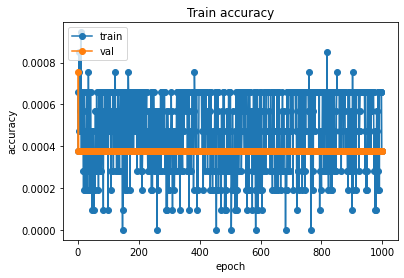

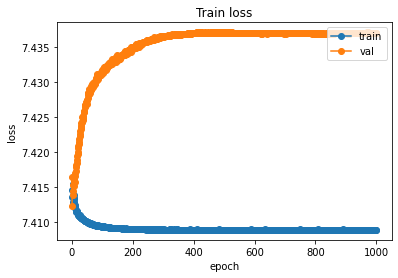

In [15]:
# Plot Learning curve
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs), history['train_acc'], "o-")
plt.plot(range(1, num_epochs+1), history['val_acc'], "o-")
plt.title('Train accuracy')
plt.ylabel('accuracy')  # Y軸ラベル
plt.xlabel('epoch')  # X軸ラベル
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Train_acc_curve.png', dpi=300)
plt.show()

# loss
plt.plot(range(1, num_epochs), history['train_loss'], "o-")
plt.plot(range(1, num_epochs+1), history['val_loss'], "o-")
plt.title('Train loss')
plt.ylabel('loss')  # Y軸ラベル
plt.xlabel('epoch')  # X軸ラベル
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('Train_loss_curve.png', dpi=300)
plt.show()